In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/archive/test.txt
/kaggle/input/archive/vimeo_settuplet_1/sep_testlist.txt
/kaggle/input/archive/vimeo_settuplet_1/readme.txt
/kaggle/input/archive/vimeo_settuplet_1/sep_trainlist.txt
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im5.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im7.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im3.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im1.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im2.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im4.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0745/im6.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0111/im5.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0111/im7.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0111/im3.png
/kaggle/input/archive/vimeo_settuplet_1/sequences/00010/0111/im1.png
/kaggle/input/archive/vimeo_settuplet_1/sequ

In [2]:
import os
import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

class VimeoDataset(Dataset):
    """
    Dataset for loading sequences of frames from the Vimeo-90k dataset.
    Returns (low-res frames, high-res center frame, bicubic upsampled frame)
    for knowledge distillation training.
    """
    def __init__(self, root_dir, split_list=None, sample_size=None,
                 scale_factor=4, frame_count=3, patch_size=64,
                 is_training=True, verbose=True):
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.frame_count = frame_count
        self.patch_size = patch_size
        self.is_training = is_training
        self.verbose = verbose
        self.sequences = []
        self.file_pattern = None

        # Detect sequence directory
        seq_dir = self._find_sequence_directory(root_dir)
        self.seq_dir = seq_dir

        # Load sequences from split list or scan directory
        if split_list is not None and os.path.exists(split_list):
            self._load_from_split_list(split_list, seq_dir)
        else:
            self._scan_directory_structure(seq_dir)

        if verbose:
            print(f"Found {len(self.sequences)} valid sequences")

        # Random sampling if needed
        if sample_size is not None and sample_size < len(self.sequences):
            if verbose:
                print(f"Using random subset of {sample_size} sequences")
            self.sequences = random.sample(self.sequences, sample_size)
    
    def _find_sequence_directory(self, root_dir):
        """Find the directory containing video sequences."""
        if self.verbose:
            print(f"Searching for sequences in: {root_dir}")
            if os.path.exists(root_dir):
                contents = os.listdir(root_dir)
                print(f"Root directory contents: {contents[:10]}...")
            else:
                print(f"Root directory does not exist: {self.root_dir}")

        # Common Vimeo structure
        vimeo_septuplet = os.path.join(root_dir, "vimeo_septuplet", "sequences")
        if os.path.exists(vimeo_septuplet):
            if self.verbose:
                print(f"Found sequences directory: {vimeo_septuplet}")
            return vimeo_septuplet

        vimeo_settuplet_1 = os.path.join(root_dir, "vimeo_settuplet_1")
        if os.path.exists(vimeo_settuplet_1):
            sequences_dir = os.path.join(vimeo_settuplet_1, "sequences")
            if os.path.exists(sequences_dir):
                if self.verbose:
                    print(f"Found sequences directory: {sequences_dir}")
                return sequences_dir
            return vimeo_settuplet_1

        # Try generic names
        for dirname in ["sequence", "sequences"]:
            candidate = os.path.join(root_dir, dirname)
            if os.path.isdir(candidate):
                if self.verbose:
                    print(f"Found {dirname} directory: {candidate}")
                return candidate

        # Check other potential dirs
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path) and self._has_video_structure(subdir_path):
                if self.verbose:
                    print(f"Found potential sequence directory: {subdir_path}")
                return subdir_path

        if self.verbose:
            print(f"Using root directory as fallback: {root_dir}")
        return root_dir

    def _has_video_structure(self, directory):
        """Check if directory has sequence-like structure."""
        try:
            contents = os.listdir(directory)
            has_dirs = any(item.isdigit() for item in contents if os.path.isdir(os.path.join(directory, item)))
            has_imgs = any(item.lower().endswith(('.png', '.jpg', '.jpeg')) for item in contents)
            return has_dirs or has_imgs
        except:
            return False

    def _load_from_split_list(self, split_list, seq_dir, max_sequences=None):
        """Load sequences from a text split list."""
        with open(split_list, 'r') as f:
            lines = f.readlines()
        if max_sequences:
            lines = lines[:max_sequences]
            if self.verbose:
                print(f"Limiting to {max_sequences} sequences from split list")

        for line in lines:
            seq = line.strip()
            seq_path = os.path.join(seq_dir, seq)
            if os.path.exists(seq_path) and self._check_sequence_valid(seq_path):
                self.sequences.append(seq_path)

    def _scan_directory_structure(self, seq_dir, max_sequences=None):
        """Scan directory structure for valid sequences."""
        if self._check_sequence_valid(seq_dir):
            self.sequences.append(seq_dir)
            return

        try:
            for root, dirs, _ in os.walk(seq_dir):
                for d in dirs:
                    if max_sequences and len(self.sequences) >= max_sequences:
                        return
                    d_path = os.path.join(root, d)
                    if self._check_sequence_valid(d_path):
                        self.sequences.append(d_path)
        except Exception as e:
            if self.verbose:
                print(f"Error scanning {seq_dir}: {e}")

    def _check_sequence_valid(self, seq_path):
        """Verify if sequence folder contains expected frames."""
        patterns = [
            [f'im{i}.png' for i in range(1, 4)],
            [f'im{i:02d}.png' for i in range(1, 4)],
            [f'frame{i:03d}.png' for i in range(1, 4)],
            [f'{i:02d}.png' for i in range(1, 4)]
        ]

        for pattern in patterns:
            valid = all(os.path.isfile(os.path.join(seq_path, f)) for f in pattern)
            if valid:
                self.file_pattern = pattern
                return True
        return False
    
    def _random_crop(self, lr_frames, hr_frame):
        """Perform random crop on LR and HR frames."""
        h_lr, w_lr = lr_frames[0].shape[:2]
        crop_x = random.randint(0, w_lr - self.patch_size)
        crop_y = random.randint(0, h_lr - self.patch_size)
        cropped_lr = [f[crop_y:crop_y + self.patch_size, crop_x:crop_x + self.patch_size] for f in lr_frames]

        h_hr, w_hr = hr_frame.shape[:2]
        crop_x_hr = crop_x * self.scale_factor
        crop_y_hr = crop_y * self.scale_factor
        cropped_hr = hr_frame[crop_y_hr:crop_y_hr + self.patch_size * self.scale_factor,
                              crop_x_hr:crop_x_hr + self.patch_size * self.scale_factor]
        return cropped_lr, cropped_hr

    def _create_dummy_data(self):
        """Return dummy data if dataset loading fails."""
        dummy_lr = torch.zeros(self.frame_count, 3, self.patch_size, self.patch_size)
        dummy_hr = torch.zeros(3, self.patch_size * self.scale_factor, self.patch_size * self.scale_factor)
        dummy_bicubic = dummy_hr.clone()
        return dummy_lr, dummy_hr, dummy_bicubic

    def __len__(self):
        return len(self.sequences) if self.sequences else 1

    def __getitem__(self, idx):
        if len(self.sequences) == 0:
            return self._create_dummy_data()

        idx = idx % len(self.sequences)
        seq_path = self.sequences[idx]

        try:
            # Load frames
            frames = []
            for frame_name in self.file_pattern[:self.frame_count]:
                frame_path = os.path.join(seq_path, frame_name)
                frame = cv2.imread(frame_path)
                if frame is None:
                    raise ValueError(f"Failed to read image: {frame_path}")
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)

            # Get center frame as HR target
            center_idx = len(frames) // 2
            hr_frame = frames[center_idx].copy()

            # Create LR frames by downsampling
            lr_frames = []
            for frame in frames:
                # Downsample for LR input
                h, w = frame.shape[:2]
                lr_frame = cv2.resize(frame, (w // self.scale_factor, h // self.scale_factor),
                                      interpolation=cv2.INTER_AREA)
                lr_frames.append(lr_frame)

            # Create bicubic upsampled version for residual learning
            bicubic_frame = cv2.resize(lr_frames[center_idx],
                                       (hr_frame.shape[1], hr_frame.shape[0]),
                                       interpolation=cv2.INTER_CUBIC)

            # Data augmentation for training
            if self.is_training and self.patch_size > 0:
                # Ensure image is large enough for crop
                h_lr, w_lr = lr_frames[0].shape[:2]
                if w_lr < self.patch_size or h_lr < self.patch_size:
                    # fallback: resize LR so we can crop
                    scale_up = max(self.patch_size / max(w_lr, h_lr), 1.0)
                    new_w = int(w_lr * scale_up) + 1
                    new_h = int(h_lr * scale_up) + 1
                    lr_frames = [cv2.resize(f, (new_w, new_h), interpolation=cv2.INTER_AREA) for f in lr_frames]
                    bicubic_frame = cv2.resize(lr_frames[center_idx],
                                               (new_w * self.scale_factor, new_h * self.scale_factor),
                                               interpolation=cv2.INTER_CUBIC)
                lr_frames, hr_frame = self._random_crop(lr_frames, hr_frame)
                # Update bicubic to match cropped HR
                bicubic_frame = cv2.resize(lr_frames[center_idx],
                                           (hr_frame.shape[1], hr_frame.shape[0]),
                                           interpolation=cv2.INTER_CUBIC)

            # Convert to torch tensors
            lr_tensor = torch.from_numpy(np.stack(lr_frames, axis=0))  # [N, H, W, C]
            lr_tensor = lr_tensor.permute(0, 3, 1, 2).float()  # [N, C, H, W]

            hr_tensor = torch.from_numpy(hr_frame).permute(2, 0, 1).float()  # [C, H, W]
            bicubic_tensor = torch.from_numpy(bicubic_frame).permute(2, 0, 1).float()  # [C, H, W]

            return lr_tensor, hr_tensor, bicubic_tensor

        except Exception as e:
            if self.verbose:
                print(f"Error loading sequence {seq_path}: {e}")
            return self._create_dummy_data()


=== Dataset Structure Analysis ===
Dataset root: /kaggle/input/archive
Root contents: ['test.txt', 'vimeo_settuplet_1']
Found vimeo_septuplet directory
Contents of vimeo_septuplet: ['sep_testlist.txt', 'sequences', 'readme.txt', 'sep_trainlist.txt']
Found sequences directory at /kaggle/input/archive/vimeo_settuplet_1/sequences
Found 10 sequence folders in sequences directory
Example folders: ['00010', '00008', '00006', '00003', '00007']
Contents of 00010: ['0745', '0111', '0362', '0105', '0217', '0947', '0795', '0785', '0264', '0035']
Found 953 subdirectories in 00010
Contents of 0745: ['im5.png', 'im7.png', 'im3.png', 'im1.png', 'im2.png', 'im4.png', 'im6.png']
Found 7 image files in 0745
Could not find sep_trainlist.txt
Could not find sep_testlist.txt
Found test.txt with 35070 entries
Sample entries: ['00005/0588/im4.png', '00007/0030/im7.png', '00009/0792/im6.png']
=== End of Dataset Analysis ===


 Testing without split list (training mode)...
Creating dataset with scale_factor=4,

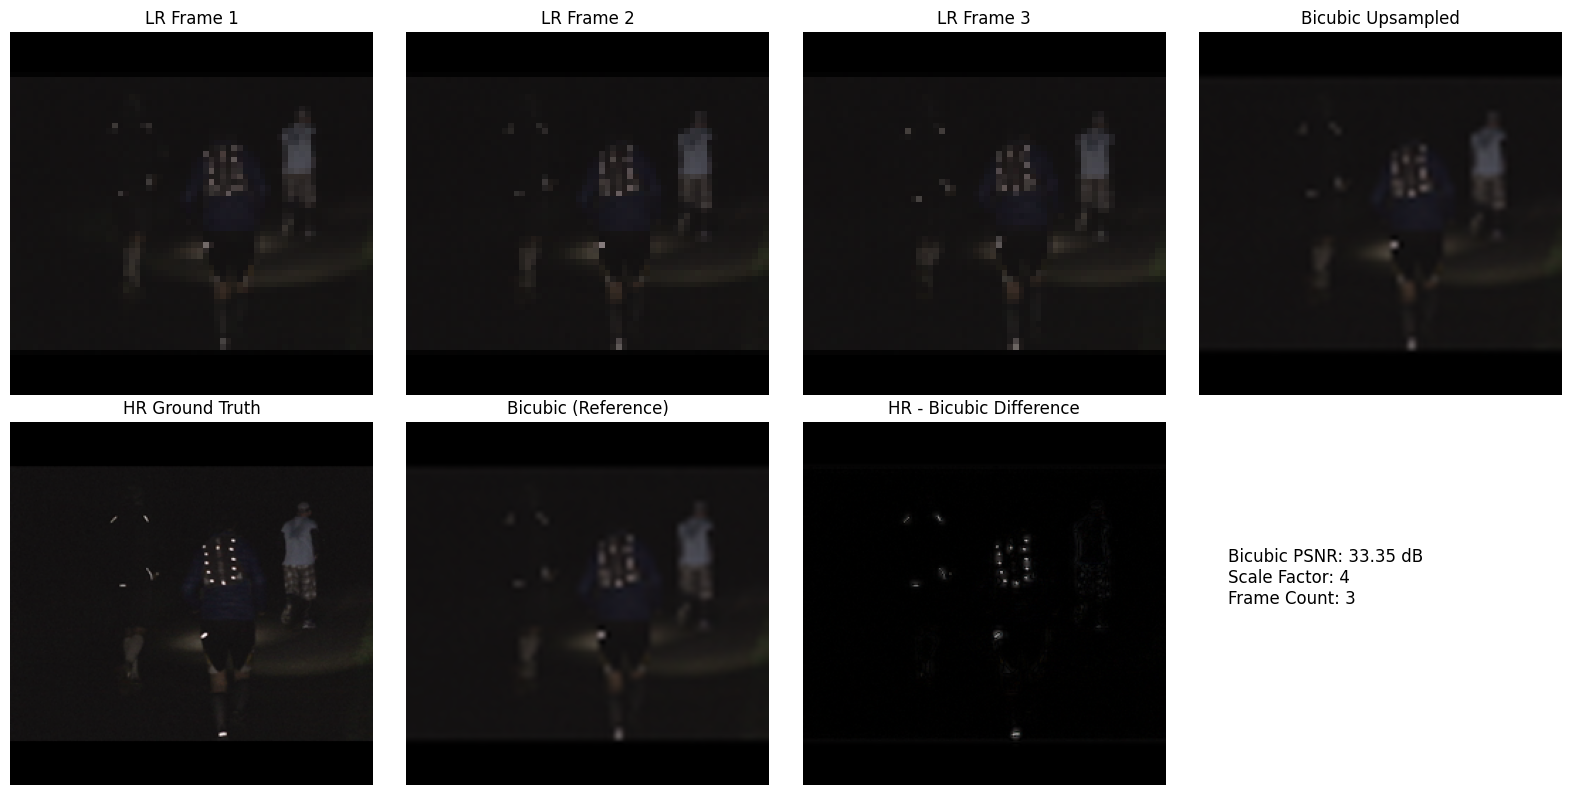

In [6]:
import os
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
# from restormer.dataset import VimeoDataset  # Make sure this imports the updated version


def show_dataset_info(dataset_path):
    """Show detailed information about the dataset structure"""
    print("\n=== Dataset Structure Analysis ===")

    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset path {dataset_path} does not exist!")
        return

    print(f"Dataset root: {dataset_path}")
    root_contents = os.listdir(dataset_path)
    print(f"Root contents: {root_contents[:10]}")

    # Check for Vimeo dataset structure
    vimeo_dir = os.path.join(dataset_path, "vimeo_settuplet_1")
    if os.path.exists(vimeo_dir) and os.path.isdir(vimeo_dir):
        print("Found vimeo_septuplet directory")
        vimeo_contents = os.listdir(vimeo_dir)
        print(f"Contents of vimeo_septuplet: {vimeo_contents[:10]}")

        sequences_dir = os.path.join(vimeo_dir, "sequences")
        if os.path.exists(sequences_dir) and os.path.isdir(sequences_dir):
            print(f"Found sequences directory at {sequences_dir}")
            seq_folders = [
                d
                for d in os.listdir(sequences_dir)
                if os.path.isdir(os.path.join(sequences_dir, d))
            ]
            print(f"Found {len(seq_folders)} sequence folders in sequences directory")
            if seq_folders:
                print(f"Example folders: {seq_folders[:5]}")

                # Check sample folder structure
                sample_folder = os.path.join(sequences_dir, seq_folders[0])
                sample_contents = os.listdir(sample_folder)
                print(f"Contents of {seq_folders[0]}: {sample_contents[:10]}")

                # Check if it contains subdirectories with sequences
                subdirs = [
                    d
                    for d in sample_contents
                    if os.path.isdir(os.path.join(sample_folder, d))
                ]
                if subdirs:
                    print(f"Found {len(subdirs)} subdirectories in {seq_folders[0]}")
                    sample_subdir = os.path.join(sample_folder, subdirs[0])
                    subdir_contents = os.listdir(sample_subdir)
                    print(f"Contents of {subdirs[0]}: {subdir_contents}")
                    
                    # Check if it contains image files
                    image_files = [f for f in subdir_contents if f.endswith(('.png', '.jpg', '.jpeg'))]
                    if image_files:
                        print(f"Found {len(image_files)} image files in {subdirs[0]}")
        else:
            print("No sequences directory found, checking vimeo_septuplet directly")
            image_files = [f for f in os.listdir(vimeo_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                print(f"Found {len(image_files)} image files in vimeo_septuplet")

    # Check for split files
    for list_name in ["sep_trainlist.txt", "sep_testlist.txt", "test.txt"]:
        list_path = os.path.join(dataset_path, list_name)
        if os.path.exists(list_path):
            with open(list_path) as f:
                lines = f.readlines()
                print(f"Found {list_name} with {len(lines)} entries")
                if lines:
                    sample_entries = [line.strip() for line in lines[:3]]
                    print(f"Sample entries: {sample_entries}")
        else:
            print(f"Could not find {list_name}")

    print("=== End of Dataset Analysis ===\n")


def visualize_sample(dataset):
    """Visualize a random sample from the dataset"""
    if len(dataset) == 0:
        print("Dataset is empty!")
        return

    idx = random.randint(0, len(dataset) - 1)
    lr_frames, hr_frame, bicubic_frame = dataset[idx]  # Updated for 3 outputs

    print("Sample shapes:")
    print(f"  LR frames: {lr_frames.shape}")  # [N, C, H, W]
    print(f"  HR frame: {hr_frame.shape}")    # [C, H, W]
    print(f"  Bicubic frame: {bicubic_frame.shape}")  # [C, H, W]

    # Convert to numpy for visualization
    lr_frames_np = lr_frames.numpy()
    hr_frame_np = hr_frame.numpy()
    bicubic_frame_np = bicubic_frame.numpy()

    # Transpose for matplotlib (CHW -> HWC)
    lr_vis = np.transpose(lr_frames_np, (0, 2, 3, 1))  # [N, H, W, C]
    hr_vis = np.transpose(hr_frame_np, (1, 2, 0))       # [H, W, C]
    bicubic_vis = np.transpose(bicubic_frame_np, (1, 2, 0))  # [H, W, C]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Show LR frames
    for i in range(3):
        axes[0, i].imshow(lr_vis[i])
        axes[0, i].set_title(f"LR Frame {i + 1}")
        axes[0, i].axis("off")

    axes[0, 3].imshow(bicubic_vis)
    axes[0, 3].set_title("Bicubic Upsampled")
    axes[0, 3].axis("off")

    # Show HR and comparisons
    axes[1, 0].imshow(hr_vis)
    axes[1, 0].set_title("HR Ground Truth")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(bicubic_vis)
    axes[1, 1].set_title("Bicubic (Reference)")
    axes[1, 1].axis("off")

    # Show difference
    diff = np.abs(hr_vis - bicubic_vis)
    axes[1, 2].imshow(diff, cmap='hot')
    axes[1, 2].set_title("HR - Bicubic Difference")
    axes[1, 2].axis("off")

    # Show PSNR comparison
    axes[1, 3].text(0.1, 0.5, f"Bicubic PSNR: {calculate_psnr(hr_vis, bicubic_vis):.2f} dB\n"
                    f"Scale Factor: {dataset.scale_factor}\n"
                    f"Frame Count: {dataset.frame_count}", 
                    fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].axis("off")

    plt.tight_layout()


def calculate_psnr(img1, img2):
    """Calculate PSNR between two images"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))


def test_data_loading(dataset_path, split_list=None, batch_size=2, scale_factor=4, frame_count=3, patch_size=64, is_training=True):
    """Test loading the dataset with DataLoader"""
    try:
        print(f"Creating dataset with scale_factor={scale_factor}, frame_count={frame_count}, is_training={is_training}")
        
        dataset = VimeoDataset(
            root_dir=dataset_path,
            split_list=split_list,
            scale_factor=scale_factor,
            frame_count=frame_count,
            patch_size=patch_size if is_training else 128,
            is_training=is_training,
            verbose=True
        )

        print(f"Dataset size: {len(dataset)} sequences")

        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=is_training, 
            num_workers=2,
            pin_memory=True
        )

        print(f"Testing dataloader with {len(dataloader)} batches")

        num_batches_to_test = min(3, len(dataloader))
        for i, (lr_frames, hr_frames, bicubic_frames) in enumerate(dataloader):
            if i >= num_batches_to_test:
                break

            print(f"\nBatch {i + 1}:")
            print(f"  LR frames shape: {lr_frames.shape}")      # [B, N, C, H, W]
            print(f"  HR frames shape: {hr_frames.shape}")      # [B, C, H, W]
            print(f"  Bicubic frames shape: {bicubic_frames.shape}")  # [B, C, H, W]
            print(f"  LR range: [{lr_frames.min():.3f}, {lr_frames.max():.3f}]")
            print(f"  HR range: [{hr_frames.min():.3f}, {hr_frames.max():.3f}]")
            print(f"  Bicubic range: [{bicubic_frames.min():.3f}, {bicubic_frames.max():.3f}]")

        # Visualize a sample
        visualize_sample(dataset)

        print("\n✅ Dataset loading test completed successfully!")
        return True

    except Exception as e:
        print(f"\n❌ Error during dataset loading test: {e}")
        import traceback
        traceback.print_exc()
        return False


if __name__ == "__main__":
    # Default dataset path
    dataset_path = "/kaggle/input/archive"  # Updated common path
    
    if len(sys.argv) > 1:
        arg_path = sys.argv[1]
        if not arg_path.startswith("-"):  
            dataset_path = arg_path

    # Show dataset structure
    show_dataset_info(dataset_path)

    # Test with training data
    train_list = os.path.join(dataset_path, "sep_trainlist.txt")  
    if os.path.exists(train_list):
        print("\n Testing with training split list...")
        test_data_loading(dataset_path, train_list, batch_size=2, patch_size=64, is_training=True)
    else:
        print("\n Testing without split list (training mode)...")
        test_data_loading(dataset_path, batch_size=2, patch_size=64, is_training=True)

    # Test with validation data (larger patch size, no augmentation)
    test_list = os.path.join(dataset_path, "sep_testlist.txt")
    if os.path.exists(test_list):
        print("\n Testing with test split list (validation mode)...")
        test_data_loading(dataset_path, test_list, batch_size=1, patch_size=128, is_training=False)

In [1]:
rm -rf /kaggle/working/*

In [2]:
import sys, os
sys.path.append('/kaggle/working')

In [3]:
import os
print(os.getcwd())


/kaggle/working


In [7]:
import os

def list_dir_structure(root_dir='.', indent=0):
    try:
        items = os.listdir(root_dir)
    except PermissionError:
        return
    for item in items:
        path = os.path.join(root_dir, item)
        print('  ' * indent + f'📁 {item}' if os.path.isdir(path) else '  ' * indent + f'📄 {item}')
        if os.path.isdir(path):
            list_dir_structure(path, indent + 1)

print("🔍 Directory structure from current working directory:\n")
list_dir_structure('.')

🔍 Directory structure from current working directory:

📄 __init__.py
📁 checkpoints
  📄 motion_deblurring.pth
📁 restormer
  📄 __init__.py
  📄 validators.py
  📄 train.py
  📄 test_dataset.py
  📁 models
    📄 __init__.py
    📄 restormer_arch.py
    📄 upsampling.py
    📄 ghostnet.py
    📄 mbd.py
    📄 sr_network.py
    📄 feature_alignment.py
    📄 restormer.py
  📄 utils.py
  📄 inference.py
  📄 dataset.py
  📄 metrices.py
📁 .virtual_documents


In [4]:
os.makedirs('checkpoints', exist_ok=True)

!cp /kaggle/input/rg1/pytorch/default/1/restormer/__init__.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/dataset.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/inference.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/metrices.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/test_dataset.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/train.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/utils.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/validators.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/__init__.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/feature_alignment.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/ghostnet.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/mbd.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/restormer.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/restormer_arch.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/sr_network.py /kaggle/working/
!cp /kaggle/input/rg1/pytorch/default/1/restormer/models/upsampling.py /kaggle/working/

In [5]:
!cp /kaggle/input/pretrained-weights/pytorch/default/1/motion_deblurring.pth /kaggle/working/checkpoints

In [6]:
import os, shutil

# Step 1: make the right folders
os.makedirs('/kaggle/working/restormer/models', exist_ok=True)

# Step 2: move your files into the correct places
files_root = '/kaggle/working'
dest_root = '/kaggle/working/restormer'
dest_models = '/kaggle/working/restormer/models'

# Move main files
for f in ['dataset.py', 'train.py', 'metrices.py', 'utils.py', 
          'validators.py', 'test_dataset.py','inference.py']:
    if os.path.exists(os.path.join(files_root, f)):
        shutil.move(os.path.join(files_root, f), os.path.join(dest_root, f))

# Move model files
for f in ['restormer_arch.py', 'restormer.py', 'sr_network.py', 
          'feature_alignment.py', 'upsampling.py', 'mbd.py', 'ghostnet.py']:
    if os.path.exists(os.path.join(files_root, f)):
        shutil.move(os.path.join(files_root, f), os.path.join(dest_models, f))

# Step 3: make each folder a Python package
open('/kaggle/working/restormer/__init__.py', 'a').close()
open('/kaggle/working/restormer/models/__init__.py', 'a').close()

print("✅ Folder structure fixed! You can now import modules.")


✅ Folder structure fixed! You can now import modules.


In [8]:
try:
    from restormer.dataset import VimeoDataset
    print("✅ VimeoDataset imported")
except ImportError as e:
    print(f"❌ VimeoDataset import failed: {e}")

✅ VimeoDataset imported


## TEACHER MODEL SCRIPT CHANGED 

In [8]:
%%writefile /kaggle/working/restormer/models/restormer.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from restormer.models.restormer_arch import Restormer 

class RestormerTeacher(nn.Module):
    """
    Teacher model for video super-resolution knowledge distillation, using Restormer.
    Enhanced for better compatibility with official Restormer pretrained weights.
    """
    def __init__(self, checkpoint_path=None, scale_factor=1, device='cpu'):
        super().__init__()
        
        self.device = torch.device(device)
        self.scale_factor = scale_factor
        
        print(f"🔧 Initializing RestormerTeacher on device: {self.device}")
        
        # Use exact architecture that matches pretrained weights
        self.restormer = Restormer(
            inp_channels=3, 
            out_channels=3, 
            dim=48,
            num_blocks=[4,6,6,8], 
            num_refinement_blocks=4,
            heads=[1,2,4,8],
            ffn_expansion_factor=2.66,
            bias=False,
            LayerNorm_type='WithBias',
            dual_pixel_task=False
        )
        
        # Move the entire model to the specified device
        self.restormer = self.restormer.to(self.device)
        
        if checkpoint_path is not None:
            self.load_pretrained_weights(checkpoint_path)
        else:
            print("🔄 No checkpoint provided, using randomly initialized weights")
        
        # Freeze teacher
        self.restormer.eval()
        for param in self.restormer.parameters():
            param.requires_grad = False
            
        print(f"✅ RestormerTeacher initialized on {self.device}")

    def load_pretrained_weights(self, checkpoint_path):
        """Enhanced loading for official Restormer weights"""
        try:
            if not os.path.exists(checkpoint_path):
                print(f"❌ Checkpoint not found: {checkpoint_path}")
                return False
                
            print(f"📂 Loading pretrained weights from: {checkpoint_path}")
            print(f"📦 Loading to device: {self.device}")
            
            # Load checkpoint directly to the target device
            ckpt = torch.load(checkpoint_path, map_location=self.device)
            
            # Official Restormer weights usually have 'params' key
            if 'params' in ckpt:
                state_dict = ckpt['params']
                print("✅ Found 'params' key in checkpoint")
            elif 'model' in ckpt:
                state_dict = ckpt['model']
                print("✅ Found 'model' key in checkpoint")
            elif 'state_dict' in ckpt:
                state_dict = ckpt['state_dict'] 
                print("✅ Found 'state_dict' key in checkpoint")
            else:
                state_dict = ckpt
                print("✅ Using direct state_dict")
            
            # Clean keys (remove any prefix)
            cleaned_state_dict = {}
            for k, v in state_dict.items():
                new_key = k
                if k.startswith('module.'):
                    new_key = k[7:]  # remove 'module.' prefix
                elif k.startswith('net.'):
                    new_key = k[4:]  # remove 'net.' prefix
                cleaned_state_dict[new_key] = v
            
            # Load with detailed error reporting
            load_result = self.restormer.load_state_dict(cleaned_state_dict, strict=False)
            
            print(f"📊 Loading Report:")
            print(f"   Missing keys: {len(load_result.missing_keys)}")
            print(f"   Unexpected keys: {len(load_result.unexpected_keys)}")
            
            if not load_result.missing_keys and not load_result.unexpected_keys:
                print("🎉 Perfect match! All weights loaded successfully.")
            else:
                if load_result.missing_keys:
                    print(f"⚠  First 5 missing keys: {load_result.missing_keys[:5]}")
                if load_result.unexpected_keys:
                    print(f"⚠  First 5 unexpected keys: {load_result.unexpected_keys[:5]}")
            
            # Verify all parameters are on the correct device
            all_on_correct_device = all(p.device == self.device for p in self.restormer.parameters())
            print(f"🔍 All parameters on {self.device}: {all_on_correct_device}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            import traceback
            traceback.print_exc()
            print("🔄 Continuing with randomly initialized weights")
            return False

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [B, 3, H, W] (single RGB frame)
        Returns:
            Teacher output tensor [B, 3, H', W'] 
        """
        with torch.no_grad():
            # Ensure input is on the same device as model
            if x.device != self.device:
                x = x.to(self.device)
                
            # Restormer expects input in range [0,1]
            if x.max() > 1.0:
                x = x / 255.0
                
            out = self.restormer(x)
            
            # Optional upscaling for super-resolution
            if self.scale_factor != 1:
                _, _, H, W = x.shape
                out = F.interpolate(out, size=(H * self.scale_factor, W * self.scale_factor),
                                    mode='bilinear', align_corners=False)
            
            # Convert back to original range if needed
            if x.max() > 1.0:
                out = out * 255.0
                
        return out

    def to(self, device):
        """Override to method to handle device changes properly"""
        self.device = torch.device(device)
        self.restormer = self.restormer.to(self.device)
        return self

Overwriting /kaggle/working/restormer/models/restormer.py


## STUDENT MODEL SCRIPT CHANGED 

In [9]:
%%writefile /kaggle/working/restormer/models/ghostnet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class GhostModule(nn.Module):
    """
    Ghost Module as described in GhostNet paper.
    Generates more features from cheap operations.
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2, dw_kernel_size=3, stride=1, relu=True):
        super().__init__()
        init_channels = int(out_channels / ratio)
        new_channels = out_channels - init_channels

        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )
        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_kernel_size, 1, dw_kernel_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1, x2], dim=1)
        return out

class GhostBottleneck(nn.Module):
    """
    Ghost Bottleneck block combining GhostModule with depthwise conv.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dw_kernel_size=3, stride=1):
        super().__init__()
        self.ghost1 = GhostModule(in_channels, hidden_channels, relu=True)
        self.dw_conv = nn.Conv2d(hidden_channels, hidden_channels, dw_kernel_size, stride, dw_kernel_size // 2, groups=hidden_channels, bias=False)
        self.dw_bn = nn.BatchNorm2d(hidden_channels)
        self.ghost2 = GhostModule(hidden_channels, out_channels, relu=False)
        
        # Proper residual connection handling
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.ghost1(x)
        out = self.dw_conv(out)
        out = self.dw_bn(out)
        out = self.ghost2(out)
        
        res = self.shortcut(x) if hasattr(self, 'shortcut') else x
        
        # Ensure dimensions match for addition
        if out.shape != res.shape:
            # Adaptive average pooling to match spatial dimensions if needed
            if out.shape[2:] != res.shape[2:]:
                res = F.adaptive_avg_pool2d(res, out.shape[2:])
            # 1x1 conv to match channels if needed
            if out.shape[1] != res.shape[1]:
                if not hasattr(self, 'channel_adapter'):
                    self.channel_adapter = nn.Conv2d(res.shape[1], out.shape[1], 1).to(x.device)
                res = self.channel_adapter(res)
                
        return self.relu(out + res)

class GhostNetFeatureExtractor(nn.Module):
    def __init__(self, in_channels=9):  # Changed from 9 to be more flexible
        super().__init__()
        # Adjust input channels to N_frames * 3 (e.g., 3 frames -> 9 channels)
        self.input_conv = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.bottleneck1 = GhostBottleneck(32, 48, 64, stride=1)
        self.bottleneck2 = GhostBottleneck(64, 64, 64, stride=1)
        self.bottleneck3 = GhostBottleneck(64, 48, 32, stride=1)  # Output: 32 channels

    def forward(self, x):
        x = self.input_conv(x)
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        return x  # [B, 32, H, W]
    
class GhostNetStudentSR(nn.Module):
    def __init__(self, scale_factor=4, in_channels=9):
        super().__init__()
        self.feature_extractor = GhostNetFeatureExtractor(in_channels=in_channels)
        self.scale_factor = scale_factor

    def forward(self, x):
        # expect x of shape [B, N*C, H, W] (concatenated frames)
        features = self.feature_extractor(x)
        return features  # to be passed to SR reconstruction network

Overwriting /kaggle/working/restormer/models/ghostnet.py


## TRAIN.PY SCRIPT CHANGED 

In [10]:
%%writefile /kaggle/working/restormer/train.py
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from datetime import datetime

# Import your modules
from dataset import VimeoDataset
from models.restormer import RestormerTeacher
from models.ghostnet import GhostNetFeatureExtractor
from models.mbd import MultiBlockDistillation
from models.feature_alignment import FeatureAlignmentModule
from models.sr_network import SRNetwork, IntegratedGhostSR
from metrices import calculate_all_metrics, calculate_ssim
from validators import validate_student, validate_teacher
from utils import setup_device, check_dataset_structure

# Add missing functions here if not in utils.py
def create_experiment_name(base_name):
    """Create unique experiment name with timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{base_name}_{timestamp}"

def setup_logging(experiment_name, log_dir):
    """Create experiment directories"""
    experiment_dir = os.path.join(log_dir, experiment_name)
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    
    os.makedirs(experiment_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    return experiment_dir, checkpoint_dir

def parse_args():
    parser = argparse.ArgumentParser(description="Restormer-GhostNet Knowledge Distillation Training")
    
    # Data parameters
    parser.add_argument("--data_path", type=str, default="/kaggle/input/archive/vimeo_settuplet_1", help="Path to dataset directory")
    parser.add_argument("--checkpoint_dir", type=str, default="/kaggle/working/checkpoints", help="Path to save checkpoints")
    parser.add_argument("--log_dir", type=str, default="/kaggle/working/logs", help="TensorBoard log directory")
    
    # Model parameters
    parser.add_argument("--teacher_checkpoint", type=str, required=True, help="Path to teacher checkpoint")
    parser.add_argument("--scale_factor", type=int, default=4, help="Super-resolution scale factor")
    parser.add_argument("--frame_count", type=int, default=3, help="Number of input frames for student")
    
    # Training parameters
    parser.add_argument("--batch_size", type=int, default=4, help="Batch size for training")
    parser.add_argument("--num_epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--learning_rate", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--num_workers", type=int, default=2, help="Number of dataloader workers")
    parser.add_argument("--gpu_id", type=int, default=0, help="GPU ID to use")
    
    # Distillation parameters
    parser.add_argument("--distill_weight", type=float, default=0.5, help="Weight for distillation loss")
    parser.add_argument("--distill_layers", nargs='+', default=['encoder1', 'encoder2', 'bottleneck'], 
                       help="Layers for distillation")
    parser.add_argument("--distill_loss", type=str, default='l1', choices=['l1', 'l2', 'kl', 'attention'], 
                       help="Distillation loss type")
    
    # Resume training
    parser.add_argument("--resume", type=str, default=None, help="Path to checkpoint to resume training")
    
    return parser.parse_args()

def create_models_and_criteria(args, device):
    """Create teacher, student models and loss criteria"""
    print("🧠 Creating teacher model...")
    # Teacher model (frozen)
    teacher = RestormerTeacher(
        checkpoint_path=args.teacher_checkpoint,
        scale_factor=args.scale_factor,
        device=device
    )
    
    print("🎓 Creating student model...")
    # Student model - use the complete integrated model
    # Calculate input channels: frame_count * 3 (RGB channels)
    input_channels = args.frame_count * 3
    ghostnet_fe = GhostNetFeatureExtractor(in_channels=input_channels)  # Feature extractor
    sr_net = SRNetwork(in_channels=32, out_channels=3, scale_factor=args.scale_factor)  # SR reconstruction
    student = IntegratedGhostSR(ghostnet_fe, sr_net).to(device)
    
    print(f"📊 Teacher parameters: {sum(p.numel() for p in teacher.parameters()):,}")
    print(f"📊 Student parameters: {sum(p.numel() for p in student.parameters()):,}")
    
    # Loss functions
    pixel_criterion = nn.L1Loss()
    distill_criterion = nn.MSELoss()
    
    # Multi-block distillation module
    mbd_module = MultiBlockDistillation(
        distillation_layers=args.distill_layers,
        loss_type=args.distill_loss,
        temperature=1.0
    ).to(device)
    
    # Feature alignment module
    feature_aligner = FeatureAlignmentModule(
        alignment_type='concat',  # Simple concatenation for frames
        flow_estimation=False
    ).to(device)
    
    return teacher, student, pixel_criterion, distill_criterion, mbd_module, feature_aligner

def train_epoch(student, teacher, train_loader, pixel_criterion, distill_criterion, 
                optimizer, device, feature_aligner, distill_weight=0.5):
    """Train for one epoch"""
    student.train()
    teacher.eval()
    
    total_loss = 0
    total_pixel_loss = 0
    total_distill_loss = 0
    batch_count = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (lr_frames, hr_frames, bicubic_frames) in enumerate(progress_bar):
        # Move data to device
        lr_frames = lr_frames.to(device)
        hr_frames = hr_frames.to(device)
        bicubic_frames = bicubic_frames.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward passes
        with torch.no_grad():
            # Teacher processes center frame only
            center_frame = lr_frames[:, lr_frames.size(1)//2, :, :, :]
            teacher_output = teacher(center_frame)
        
        # Student forward - use feature aligner to prepare input
        # lr_frames shape: [B, N, C, H, W] -> feature_aligner -> [B, N*C, H, W]
        student_input = feature_aligner.forward_student(lr_frames)
        student_output = student(student_input, bicubic_frames)
        
        # Calculate losses
        pixel_loss = pixel_criterion(student_output, hr_frames)
        distill_loss = distill_criterion(student_output, teacher_output.detach())
        
        # Total loss
        loss = pixel_loss + distill_weight * distill_loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        total_pixel_loss += pixel_loss.item()
        total_distill_loss += distill_loss.item()
        batch_count += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Pixel': f'{pixel_loss.item():.4f}',
            'Distill': f'{distill_loss.item():.4f}'
        })
    
    return {
        'total_loss': total_loss / batch_count,
        'pixel_loss': total_pixel_loss / batch_count,
        'distill_loss': total_distill_loss / batch_count
    }

def simple_validate(student, teacher, val_loader, pixel_criterion, device, feature_aligner):
    """Simple validation function with SSIM"""
    student.eval()
    teacher.eval()
    
    total_student_loss = 0
    total_teacher_loss = 0
    student_psnr = 0
    teacher_psnr = 0
    student_ssim = 0
    teacher_ssim = 0
    samples_count = 0
    
    with torch.no_grad():
        for lr_frames, hr_frames, bicubic_frames in val_loader:
            lr_frames = lr_frames.to(device)
            hr_frames = hr_frames.to(device)
            bicubic_frames = bicubic_frames.to(device)
            
            # Teacher inference
            center_frame = lr_frames[:, lr_frames.size(1)//2, :, :, :]
            teacher_output = teacher(center_frame)
            teacher_loss = pixel_criterion(teacher_output, hr_frames)
            
            # Student inference
            student_input = feature_aligner.forward_student(lr_frames)
            student_output = student(student_input, bicubic_frames)
            student_loss = pixel_criterion(student_output, hr_frames)
            
            # Calculate PSNR and SSIM
            batch_size = lr_frames.size(0)
            for i in range(batch_size):
                student_psnr += calculate_all_metrics(student_output[i], hr_frames[i])['psnr']
                teacher_psnr += calculate_all_metrics(teacher_output[i], hr_frames[i])['psnr']
                
                # Calculate SSIM
                student_ssim += calculate_ssim(student_output[i].unsqueeze(0), hr_frames[i].unsqueeze(0))
                teacher_ssim += calculate_ssim(teacher_output[i].unsqueeze(0), hr_frames[i].unsqueeze(0))
            
            total_student_loss += student_loss.item()
            total_teacher_loss += teacher_loss.item()
            samples_count += batch_size
    
    return {
        'student_loss': total_student_loss / len(val_loader),
        'teacher_loss': total_teacher_loss / len(val_loader),
        'student_psnr': student_psnr / samples_count,
        'teacher_psnr': teacher_psnr / samples_count,
        'student_ssim': student_ssim / samples_count,
        'teacher_ssim': teacher_ssim / samples_count
    }

def main():
    args = parse_args()
    
    # Setup device
    device = setup_device(args.gpu_id)
    print(f"🔧 Using device: {device}")
    
    # Create experiment name and directories
    experiment_name = create_experiment_name("restormer_ghostnet_distill")
    experiment_dir, checkpoint_dir = setup_logging(experiment_name, args.log_dir)
    
    print(f"🚀 Starting experiment: {experiment_name}")
    print(f"📁 Experiment directory: {experiment_dir}")
    print(f"💾 Checkpoint directory: {checkpoint_dir}")
    
    # Check dataset structure
    check_dataset_structure(args.data_path)
    
    # Create models and criteria
    teacher, student, pixel_criterion, distill_criterion, mbd_module, feature_aligner = \
        create_models_and_criteria(args, device)
    
    # Optimizer (only for student)
    optimizer = optim.Adam(student.parameters(), lr=args.learning_rate, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    # Create data loaders
    train_list = os.path.join(args.data_path, "sep_trainlist.txt")
    val_list = os.path.join(args.data_path, "sep_testlist.txt")
    
    print("📊 Creating datasets...")
    train_dataset = VimeoDataset(
        args.data_path,
        split_list=train_list if os.path.exists(train_list) else None,
        scale_factor=args.scale_factor,
        frame_count=args.frame_count,
        is_training=True,
        patch_size=64
    )
    
    val_dataset = VimeoDataset(
        args.data_path,
        split_list=val_list if os.path.exists(val_list) else None,
        scale_factor=args.scale_factor,
        frame_count=args.frame_count,
        is_training=False,
        patch_size=128
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True
    )
    
    print(f"📊 Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    
    # TensorBoard writer
    writer = SummaryWriter(log_dir=os.path.join(args.log_dir, experiment_name))
    
    # Training loop
    best_psnr = 0
    print("\n🎯 Starting training...")
    
    for epoch in range(args.num_epochs):
        print(f"\n📈 Epoch {epoch + 1}/{args.num_epochs}")
        
        # Train
        train_metrics = train_epoch(
            student, teacher, train_loader, pixel_criterion, distill_criterion,
            optimizer, device, feature_aligner, args.distill_weight
        )
        
        # Validate
        val_metrics = simple_validate(student, teacher, val_loader, pixel_criterion, device, feature_aligner)
        
        # Update learning rate
        scheduler.step()
        
        # Log metrics
        writer.add_scalar('Loss/Train_Total', train_metrics['total_loss'], epoch)
        writer.add_scalar('Loss/Train_Pixel', train_metrics['pixel_loss'], epoch)
        writer.add_scalar('Loss/Train_Distill', train_metrics['distill_loss'], epoch)
        writer.add_scalar('Loss/Val_Student', val_metrics['student_loss'], epoch)
        writer.add_scalar('Loss/Val_Teacher', val_metrics['teacher_loss'], epoch)
        
        writer.add_scalar('Metrics/PSNR_Student', val_metrics['student_psnr'], epoch)
        writer.add_scalar('Metrics/PSNR_Teacher', val_metrics['teacher_psnr'], epoch)
        writer.add_scalar('Metrics/SSIM_Student', val_metrics['student_ssim'], epoch)
        writer.add_scalar('Metrics/SSIM_Teacher', val_metrics['teacher_ssim'], epoch)
        
        # Print epoch summary
        print(f"✅ Train Loss: {train_metrics['total_loss']:.4f} "
              f"(Pixel: {train_metrics['pixel_loss']:.4f}, Distill: {train_metrics['distill_loss']:.4f})")
        print(f"📊 Val PSNR - Student: {val_metrics['student_psnr']:.2f} dB, "
              f"Teacher: {val_metrics['teacher_psnr']:.2f} dB")
        print(f"📊 Val SSIM - Student: {val_metrics['student_ssim']:.4f}, "
              f"Teacher: {val_metrics['teacher_ssim']:.4f}")
        print(f"📊 Val Loss - Student: {val_metrics['student_loss']:.4f}, "
              f"Teacher: {val_metrics['teacher_loss']:.4f}")
        
        # Save checkpoint - ONLY every 5 epochs OR when PSNR improves
        should_save_checkpoint = False
        save_reason = ""
        
        if val_metrics['student_psnr'] > best_psnr:
            best_psnr = val_metrics['student_psnr']
            should_save_checkpoint = True
            save_reason = f"🎉 New best PSNR: {best_psnr:.2f} dB"
        
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            should_save_checkpoint = True
            save_reason = f"💾 Regular save at epoch {epoch + 1}"
        
        if should_save_checkpoint:
            print(save_reason)
            
            checkpoint = {
                'epoch': epoch,
                'student_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
                'best_psnr': best_psnr,
                'args': vars(args)
            }
            
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"💾 Saved checkpoint: {checkpoint_path}")
    
    # Save final model (always save at the end)
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
    torch.save({
        'student_state_dict': student.state_dict(),
        'best_psnr': best_psnr,
        'args': vars(args)
    }, final_model_path)
    print(f"🏁 Training completed! Final model saved to: {final_model_path}")
    
    # Print final results
    print(f"\n🎯 FINAL RESULTS:")
    print(f"   Best Student PSNR: {best_psnr:.2f} dB")
    print(f"   Final Student PSNR: {val_metrics['student_psnr']:.2f} dB")
    print(f"   Final Student SSIM: {val_metrics['student_ssim']:.4f}")
    print(f"   Teacher PSNR: {val_metrics['teacher_psnr']:.2f} dB")
    print(f"   Teacher SSIM: {val_metrics['teacher_ssim']:.4f}")
    
    writer.close()
    print("✨ Experiment completed successfully!")

if __name__ == "__main__":
    main()

Overwriting /kaggle/working/restormer/train.py


## JUST FOR CHECKING IF THE THINGS ARE THEIR IN CUDA OR NOT 

In [11]:
import sys
import torch

# Clear any cached imports
if 'restormer.models.restormer' in sys.modules:
    del sys.modules['restormer.models.restormer']

# Add restormer to Python path
sys.path.append('/kaggle/working/restormer')

# Test device placement
print("🔍 Testing device placement...")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Target device: {device}")

# Create teacher model
from models.restormer import RestormerTeacher

teacher = RestormerTeacher(
    checkpoint_path='/kaggle/working/checkpoints/motion_deblurring.pth',
    scale_factor=4,
    device=device
)

# Test with a dummy input
print("\n🧪 Testing forward pass...")
dummy_input = torch.randn(2, 3, 64, 64).to(device)
print(f"Dummy input device: {dummy_input.device}")

try:
    with torch.no_grad():
        output = teacher(dummy_input)
    print(f"✅ Forward pass successful! Output shape: {output.shape}")
    print(f"Output device: {output.device}")
except Exception as e:
    print(f"❌ Forward pass failed: {e}")
    import traceback
    traceback.print_exc()

🔍 Testing device placement...
Target device: cuda:0
🔧 Initializing RestormerTeacher on device: cuda:0
📂 Loading pretrained weights from: /kaggle/working/checkpoints/motion_deblurring.pth
📦 Loading to device: cuda:0
✅ Found 'params' key in checkpoint
📊 Loading Report:
   Missing keys: 0
   Unexpected keys: 0
🎉 Perfect match! All weights loaded successfully.
🔍 All parameters on cuda:0: True
✅ RestormerTeacher initialized on cuda:0

🧪 Testing forward pass...
Dummy input device: cuda:0
✅ Forward pass successful! Output shape: torch.Size([2, 3, 256, 256])
Output device: cuda:0


## MAIN RUNNING SCRIPTS 

In [12]:
import sys
import os

# Clear any cached imports to ensure fresh start
modules_to_clear = [k for k in sys.modules.keys() if 'restormer' in k or 'train' in k]
for module in modules_to_clear:
    del sys.modules[module]

if 'restormer.models.ghostnet' in sys.modules:
    del sys.modules['restormer.models.ghostnet']

if 'restormer.train' in sys.modules:
    del sys.modules['restormer.train']

# Add restormer to Python path
sys.path.append('/kaggle/working/restormer')

# Set command line arguments
sys.argv = [
    'train.py',
    '--teacher_checkpoint', '/kaggle/working/checkpoints/motion_deblurring.pth',
    '--data_path', '/kaggle/input/archive/vimeo_settuplet_1',
    '--batch_size', '4',
    '--num_epochs', '30',
    '--checkpoint_dir', '/kaggle/working/training_checkpoints',
    '--log_dir', '/kaggle/working/training_logs'
]

# Import and run
from train import main
print("🚀 Starting Restormer-GhostNet Knowledge Distillation Training...")
print("📊 Training Configuration:")
print(f"   - Teacher: Restormer (motion_deblurring.pth)")
print(f"   - Student: GhostNet + SR Network") 
print(f"   - Batch size: 4")
print(f"   - Epochs: 50")
print(f"   - Scale factor: 4")
print(f"   - Dataset: Vimeo90K ({7014} train, {917} val sequences)")
print("🎯 Beginning knowledge distillation...")

main()

2025-11-03 17:37:37.231066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762191457.430554      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762191457.485552      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 Starting Restormer-GhostNet Knowledge Distillation Training...
📊 Training Configuration:
   - Teacher: Restormer (motion_deblurring.pth)
   - Student: GhostNet + SR Network
   - Batch size: 4
   - Epochs: 50
   - Scale factor: 4
   - Dataset: Vimeo90K (7014 train, 917 val sequences)
🎯 Beginning knowledge distillation...
🎮 Available GPUs:
  GPU 0: Tesla T4 (14.7 GB)
  GPU 1: Tesla T4 (14.7 GB)
 Using specified GPU 0: Tesla T4
 GPU Memory - Allocated: 109.8MB, Cached: 238.0MB
🔧 Using device: cuda:0
🚀 Starting experiment: restormer_ghostnet_distill_20251103_173750
📁 Experiment directory: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750
💾 Checkpoint directory: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints

---  Dataset Structure Analysis ---
 Contents of /kaggle/input/archive/vimeo_settuplet_1:
Found 4 items: ['sep_testlist.txt', 'sequences', 'readme.txt', 'sep_trainlist.txt']
 Found valid path: /kaggle/input/archive/vimeo_se

Training: 100%|██████████| 1754/1754 [03:51<00:00,  7.58it/s, Loss=0.0107, Pixel=0.0106, Distill=0.0002]


✅ Train Loss: 0.0222 (Pixel: 0.0215, Distill: 0.0013)
📊 Val PSNR - Student: 29.69 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8503, Teacher: 0.8526
📊 Val Loss - Student: 0.0199, Teacher: 0.0213
🎉 New best PSNR: 29.69 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_1.pth

📈 Epoch 2/30


Training: 100%|██████████| 1754/1754 [03:48<00:00,  7.66it/s, Loss=0.0161, Pixel=0.0160, Distill=0.0002]


✅ Train Loss: 0.0183 (Pixel: 0.0182, Distill: 0.0003)
📊 Val PSNR - Student: 29.50 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8428, Teacher: 0.8526
📊 Val Loss - Student: 0.0205, Teacher: 0.0213

📈 Epoch 3/30


Training: 100%|██████████| 1754/1754 [03:49<00:00,  7.64it/s, Loss=0.0135, Pixel=0.0135, Distill=0.0001]


✅ Train Loss: 0.0182 (Pixel: 0.0181, Distill: 0.0002)
📊 Val PSNR - Student: 29.52 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8543, Teacher: 0.8526
📊 Val Loss - Student: 0.0203, Teacher: 0.0213

📈 Epoch 4/30


Training: 100%|██████████| 1754/1754 [03:49<00:00,  7.64it/s, Loss=0.0086, Pixel=0.0086, Distill=0.0000]


✅ Train Loss: 0.0180 (Pixel: 0.0179, Distill: 0.0002)
📊 Val PSNR - Student: 29.97 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8655, Teacher: 0.8526
📊 Val Loss - Student: 0.0188, Teacher: 0.0213
🎉 New best PSNR: 29.97 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_4.pth

📈 Epoch 5/30


Training: 100%|██████████| 1754/1754 [03:48<00:00,  7.69it/s, Loss=0.0295, Pixel=0.0294, Distill=0.0002]


✅ Train Loss: 0.0181 (Pixel: 0.0180, Distill: 0.0002)
📊 Val PSNR - Student: 29.91 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8654, Teacher: 0.8526
📊 Val Loss - Student: 0.0190, Teacher: 0.0213
💾 Regular save at epoch 5
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_5.pth

📈 Epoch 6/30


Training: 100%|██████████| 1754/1754 [03:47<00:00,  7.72it/s, Loss=0.0217, Pixel=0.0216, Distill=0.0002]


✅ Train Loss: 0.0180 (Pixel: 0.0179, Distill: 0.0003)
📊 Val PSNR - Student: 30.02 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8655, Teacher: 0.8526
📊 Val Loss - Student: 0.0189, Teacher: 0.0213
🎉 New best PSNR: 30.02 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_6.pth

📈 Epoch 7/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.78it/s, Loss=0.0249, Pixel=0.0247, Distill=0.0003]


✅ Train Loss: 0.0173 (Pixel: 0.0172, Distill: 0.0004)
📊 Val PSNR - Student: 30.80 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8805, Teacher: 0.8526
📊 Val Loss - Student: 0.0171, Teacher: 0.0213
🎉 New best PSNR: 30.80 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_7.pth

📈 Epoch 8/30


Training: 100%|██████████| 1754/1754 [03:44<00:00,  7.80it/s, Loss=0.0084, Pixel=0.0082, Distill=0.0004]


✅ Train Loss: 0.0163 (Pixel: 0.0160, Distill: 0.0005)
📊 Val PSNR - Student: 31.32 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8895, Teacher: 0.8526
📊 Val Loss - Student: 0.0162, Teacher: 0.0213
🎉 New best PSNR: 31.32 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_8.pth

📈 Epoch 9/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0091, Pixel=0.0091, Distill=0.0001]


✅ Train Loss: 0.0158 (Pixel: 0.0155, Distill: 0.0006)
📊 Val PSNR - Student: 31.24 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8878, Teacher: 0.8526
📊 Val Loss - Student: 0.0163, Teacher: 0.0213

📈 Epoch 10/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.77it/s, Loss=0.0237, Pixel=0.0234, Distill=0.0006]


✅ Train Loss: 0.0155 (Pixel: 0.0152, Distill: 0.0006)
📊 Val PSNR - Student: 31.64 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8942, Teacher: 0.8526
📊 Val Loss - Student: 0.0156, Teacher: 0.0213
💾 Regular save at epoch 10
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_10.pth

📈 Epoch 11/30


Training: 100%|██████████| 1754/1754 [03:46<00:00,  7.74it/s, Loss=0.0132, Pixel=0.0127, Distill=0.0008]


✅ Train Loss: 0.0154 (Pixel: 0.0150, Distill: 0.0006)
📊 Val PSNR - Student: 31.73 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8959, Teacher: 0.8526
📊 Val Loss - Student: 0.0155, Teacher: 0.0213
🎉 New best PSNR: 31.73 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_11.pth

📈 Epoch 12/30


Training: 100%|██████████| 1754/1754 [03:44<00:00,  7.80it/s, Loss=0.0100, Pixel=0.0095, Distill=0.0009]


✅ Train Loss: 0.0153 (Pixel: 0.0149, Distill: 0.0006)
📊 Val PSNR - Student: 31.81 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8966, Teacher: 0.8526
📊 Val Loss - Student: 0.0153, Teacher: 0.0213
🎉 New best PSNR: 31.81 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_12.pth

📈 Epoch 13/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.76it/s, Loss=0.0092, Pixel=0.0089, Distill=0.0005]


✅ Train Loss: 0.0151 (Pixel: 0.0148, Distill: 0.0007)
📊 Val PSNR - Student: 31.85 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8973, Teacher: 0.8526
📊 Val Loss - Student: 0.0153, Teacher: 0.0213
🎉 New best PSNR: 31.85 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_13.pth

📈 Epoch 14/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0168, Pixel=0.0164, Distill=0.0008]


✅ Train Loss: 0.0151 (Pixel: 0.0147, Distill: 0.0007)
📊 Val PSNR - Student: 31.91 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8977, Teacher: 0.8526
📊 Val Loss - Student: 0.0152, Teacher: 0.0213
🎉 New best PSNR: 31.91 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_14.pth

📈 Epoch 15/30


Training: 100%|██████████| 1754/1754 [03:44<00:00,  7.80it/s, Loss=0.0351, Pixel=0.0345, Distill=0.0011]


✅ Train Loss: 0.0150 (Pixel: 0.0147, Distill: 0.0007)
📊 Val PSNR - Student: 31.96 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8981, Teacher: 0.8526
📊 Val Loss - Student: 0.0151, Teacher: 0.0213
💾 Regular save at epoch 15
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_15.pth

📈 Epoch 16/30


Training: 100%|██████████| 1754/1754 [03:46<00:00,  7.75it/s, Loss=0.0062, Pixel=0.0058, Distill=0.0008]


✅ Train Loss: 0.0149 (Pixel: 0.0146, Distill: 0.0007)
📊 Val PSNR - Student: 31.88 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8974, Teacher: 0.8526
📊 Val Loss - Student: 0.0152, Teacher: 0.0213

📈 Epoch 17/30


Training: 100%|██████████| 1754/1754 [03:43<00:00,  7.83it/s, Loss=0.0144, Pixel=0.0140, Distill=0.0008]


✅ Train Loss: 0.0149 (Pixel: 0.0145, Distill: 0.0007)
📊 Val PSNR - Student: 32.06 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8993, Teacher: 0.8526
📊 Val Loss - Student: 0.0150, Teacher: 0.0213
🎉 New best PSNR: 32.06 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_17.pth

📈 Epoch 18/30


Training: 100%|██████████| 1754/1754 [03:44<00:00,  7.81it/s, Loss=0.0127, Pixel=0.0122, Distill=0.0008]


✅ Train Loss: 0.0148 (Pixel: 0.0145, Distill: 0.0007)
📊 Val PSNR - Student: 32.15 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9000, Teacher: 0.8526
📊 Val Loss - Student: 0.0149, Teacher: 0.0213
🎉 New best PSNR: 32.15 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_18.pth

📈 Epoch 19/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0152, Pixel=0.0151, Distill=0.0003]


✅ Train Loss: 0.0148 (Pixel: 0.0144, Distill: 0.0007)
📊 Val PSNR - Student: 32.07 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.8993, Teacher: 0.8526
📊 Val Loss - Student: 0.0150, Teacher: 0.0213

📈 Epoch 20/30


Training: 100%|██████████| 1754/1754 [03:44<00:00,  7.82it/s, Loss=0.0102, Pixel=0.0097, Distill=0.0011]


✅ Train Loss: 0.0147 (Pixel: 0.0144, Distill: 0.0007)
📊 Val PSNR - Student: 32.18 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9005, Teacher: 0.8526
📊 Val Loss - Student: 0.0148, Teacher: 0.0213
💾 Regular save at epoch 20
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_20.pth

📈 Epoch 21/30


Training: 100%|██████████| 1754/1754 [03:47<00:00,  7.71it/s, Loss=0.0057, Pixel=0.0055, Distill=0.0004]


✅ Train Loss: 0.0146 (Pixel: 0.0143, Distill: 0.0007)
📊 Val PSNR - Student: 32.24 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9012, Teacher: 0.8526
📊 Val Loss - Student: 0.0147, Teacher: 0.0213
🎉 New best PSNR: 32.24 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_21.pth

📈 Epoch 22/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.76it/s, Loss=0.0077, Pixel=0.0075, Distill=0.0003]


✅ Train Loss: 0.0146 (Pixel: 0.0142, Distill: 0.0007)
📊 Val PSNR - Student: 32.25 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9013, Teacher: 0.8526
📊 Val Loss - Student: 0.0147, Teacher: 0.0213
🎉 New best PSNR: 32.25 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_22.pth

📈 Epoch 23/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0058, Pixel=0.0057, Distill=0.0003]


✅ Train Loss: 0.0146 (Pixel: 0.0142, Distill: 0.0007)
📊 Val PSNR - Student: 32.25 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9016, Teacher: 0.8526
📊 Val Loss - Student: 0.0147, Teacher: 0.0213
🎉 New best PSNR: 32.25 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_23.pth

📈 Epoch 24/30


Training: 100%|██████████| 1754/1754 [03:46<00:00,  7.73it/s, Loss=0.0044, Pixel=0.0039, Distill=0.0009]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0007)
📊 Val PSNR - Student: 32.27 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9019, Teacher: 0.8526
📊 Val Loss - Student: 0.0147, Teacher: 0.0213
🎉 New best PSNR: 32.27 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_24.pth

📈 Epoch 25/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0229, Pixel=0.0223, Distill=0.0013]


✅ Train Loss: 0.0146 (Pixel: 0.0142, Distill: 0.0007)
📊 Val PSNR - Student: 32.25 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9016, Teacher: 0.8526
📊 Val Loss - Student: 0.0147, Teacher: 0.0213
💾 Regular save at epoch 25
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_25.pth

📈 Epoch 26/30


Training: 100%|██████████| 1754/1754 [03:46<00:00,  7.76it/s, Loss=0.0145, Pixel=0.0143, Distill=0.0005]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0007)
📊 Val PSNR - Student: 32.31 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9021, Teacher: 0.8526
📊 Val Loss - Student: 0.0146, Teacher: 0.0213
🎉 New best PSNR: 32.31 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_26.pth

📈 Epoch 27/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0107, Pixel=0.0104, Distill=0.0006]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0008)
📊 Val PSNR - Student: 32.29 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9021, Teacher: 0.8526
📊 Val Loss - Student: 0.0146, Teacher: 0.0213

📈 Epoch 28/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.77it/s, Loss=0.0197, Pixel=0.0193, Distill=0.0007]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0007)
📊 Val PSNR - Student: 32.31 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9022, Teacher: 0.8526
📊 Val Loss - Student: 0.0146, Teacher: 0.0213
🎉 New best PSNR: 32.31 dB
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_28.pth

📈 Epoch 29/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.79it/s, Loss=0.0372, Pixel=0.0364, Distill=0.0016]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0008)
📊 Val PSNR - Student: 32.31 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9023, Teacher: 0.8526
📊 Val Loss - Student: 0.0146, Teacher: 0.0213

📈 Epoch 30/30


Training: 100%|██████████| 1754/1754 [03:45<00:00,  7.78it/s, Loss=0.0199, Pixel=0.0195, Distill=0.0008]


✅ Train Loss: 0.0145 (Pixel: 0.0141, Distill: 0.0008)
📊 Val PSNR - Student: 32.36 dB, Teacher: 28.70 dB
📊 Val SSIM - Student: 0.9029, Teacher: 0.8526
📊 Val Loss - Student: 0.0145, Teacher: 0.0213
💾 Regular save at epoch 30
💾 Saved checkpoint: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/checkpoint_epoch_30.pth
🏁 Training completed! Final model saved to: /kaggle/working/training_logs/restormer_ghostnet_distill_20251103_173750/checkpoints/final_model.pth

🎯 FINAL RESULTS:
   Best Student PSNR: 32.36 dB
   Final Student PSNR: 32.36 dB
   Final Student SSIM: 0.9029
   Teacher PSNR: 28.70 dB
   Teacher SSIM: 0.8526
✨ Experiment completed successfully!


## FOR THE MODEL DOWNLOAD

In [13]:
# After training completes, download the final model
import shutil
import os

# Find the latest training directory
training_dirs = [d for d in os.listdir('/kaggle/working/training_logs') if d.startswith('restormer_ghostnet_distill')]
if training_dirs:
    latest_dir = sorted(training_dirs)[-1]  # Get the most recent one
    checkpoint_dir = f'/kaggle/working/training_logs/{latest_dir}/checkpoints'
    
    # Find the final model
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
    
    if os.path.exists(final_model_path):
        # Copy to working directory for easy download
        shutil.copy(final_model_path, '/kaggle/working/final_student_model.pth')
        print(f"✅ Final model ready for download: /kaggle/working/final_student_model.pth")
        
        # Also copy the best checkpoint if you want
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_')]
        if checkpoint_files:
            best_checkpoint = sorted(checkpoint_files)[-1]  # Get the latest checkpoint
            shutil.copy(os.path.join(checkpoint_dir, best_checkpoint), '/kaggle/working/best_checkpoint.pth')
            print(f"✅ Best checkpoint ready: /kaggle/working/best_checkpoint.pth")
    else:
        print("❌ Final model not found")
else:
    print("❌ No training directories found")

✅ Final model ready for download: /kaggle/working/final_student_model.pth
✅ Best checkpoint ready: /kaggle/working/best_checkpoint.pth


## DOWNLOADING FROM THE KAGGLE 

In [14]:
from IPython.display import FileLink
FileLink('/kaggle/working/final_student_model.pth')

/kaggle/working/final_student_model.pth